<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available. 

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [1]:
# !pip install keras-core --upgrade
# !pip install -q keras-nlp --upgrade

# This sample uses Keras Core, the multi-backend version of Keras.
# The selected backend is TensorFlow (other supported backends are 'jax' and 'torch')
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
# import keras_core as keras
import keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

2025-07-10 16:36:48.714291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 16:36:48.804155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752161808.835862   16420 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752161808.845394   16420 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752161808.915055   16420 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
KerasNLP version: 0.21.1


/home/monkin/Desktop/llm-learn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

: 

: 

: 

## Check Available Devices

In [ ]:
# Check available devices
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(device)

if tf.config.list_physical_devices('GPU'):
    print("TensorFlow (Keras backend) is detecting at least one GPU.")

# Enable device placement logging
LOG_DEVICE_PLACEMENT = True
if LOG_DEVICE_PLACEMENT:
    tf.debugging.set_log_device_placement(True)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow (Keras backend) is detecting at least one GPU.


: 

: 

: 

: 

# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [ ]:
df_train = pd.read_csv("input/train.csv")
df_test = pd.read_csv("input/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


: 

: 

: 

: 

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


: 

: 

: 

: 

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


: 

: 

: 

: 

# Explore the dataset

In [ ]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


: 

: 

: 

: 

If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Preprocess the data

In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8   # 80% training, 20% validation. The Test set is already separated.
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE  # number of training batches per epoch
print(f"Nº of training examples: {NUM_TRAINING_EXAMPLES}")
print(f"Steps per epoch: {STEPS_PER_EPOCH} (Training batches per epoch)")

EPOCHS = 2  # number of epochs to train the model
AUTO = tf.data.experimental.AUTOTUNE    

: 

: 

: 

: 

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train["text"]    # Feature Column
y = df_train["target"]  # Target Column

# Split the data into training and validation sets randomly
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = df_test["text"]

: 

: 

: 

: 

# Load a DistilBERT model from Keras NLP

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose a DistilBERT model that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"  # Label of DistilBERT model preset

'''
Use a shorter sequence length. Sequence length is the maximum length of input sequences.
We saw above that the maximum length of a training sample is 157 characters. Thus, we can set the sequence length to 160.
'''
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(
    preset,                         # Label of DistilBERT model preset
    sequence_length=160,            # Shorter sequence length for faster training. Sequence length is the maximum length of input sequences.
    name="preprocessor_4_tweets"    # Name of the preprocessor layer
)

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    preset,                         # Label of DistilBERT model preset
    preprocessor = preprocessor,    # Preprocessor layer to apply preprocessing to raw inputs during fit(), predict(), and evaluate()
    num_classes=2                   # Number of classes in the target variable (binary classification: 0 or 1) - Disaster or Not Disaster
)

classifier.summary()

Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item_1 (GetItem)          │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

: 

: 

: 

: 

# Train your own model, fine-tuning BERT

In [ ]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),  #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-5),  # Learning rate of 1e-5 is a good starting point for fine-tuning BERT models
    metrics= ["accuracy"]  # Using accuracy as the evaluation metric
)

# Fit
history = classifier.fit(x=X_train,                         # Training data
                         y=y_train,                         # Training labels
                         batch_size=BATCH_SIZE,             
                         epochs=EPOCHS, 
                         validation_data=(X_val, y_val)     # Validation data
)

Epoch 1/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 68s 279ms/step - accuracy: 0.7079 - loss: 0.5782 - val_accuracy: 0.8345 - val_loss: 0.4018
Epoch 2/2
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - accuracy: 0.8396 - loss: 0.3859 - val_accuracy: 0.8411 - val_loss: 0.3885


: 

: 

: 

: 

In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    '''
    Displays the confusion matrix for the given true labels and predicted labels.
    '''
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, # True labels of the validation set
        np.argmax(y_pred, axis=1),  # Convert logits to class labels (predictions) by selecting the index of the maximum value along the specified axis -- Deterministic prediction.
        display_labels=["Not Disaster","Disaster"], # Define the labels for the Positive and Negative classes
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))    # Calculate F1 Score

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))    # Set the title of the confusion matrix plot


: 

: 

: 

: 

191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step


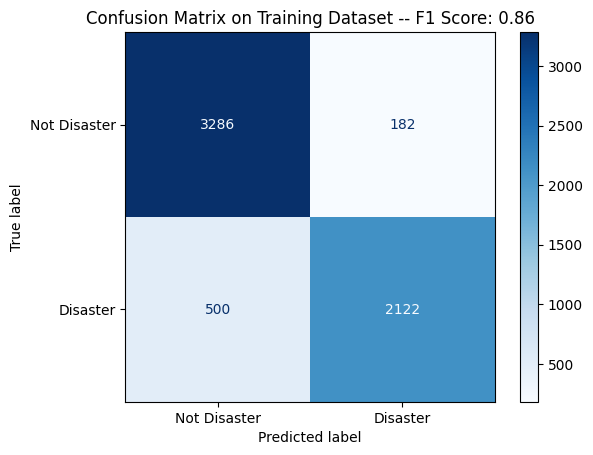

: 

: 

: 

: 

In [ ]:
y_pred_train = classifier.predict(X_train)  # Predict on the training set

displayConfusionMatrix(y_train, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step


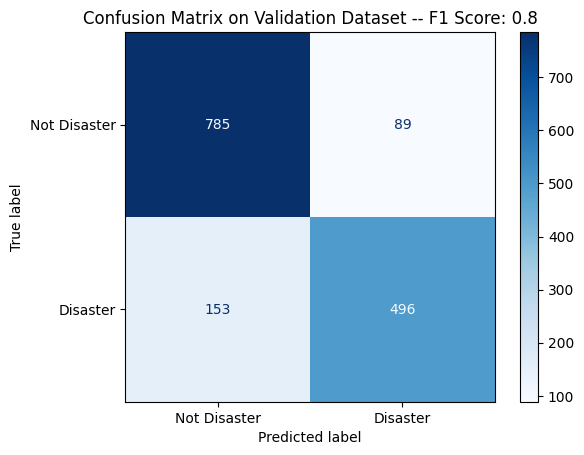

: 

: 

: 

: 

In [ ]:
y_pred_val = classifier.predict(X_val)  # Predict on the validation set

displayConfusionMatrix(y_val, y_pred_val, "Validation")

# Generate the submission file 

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [ ]:
sample_submission = pd.read_csv("input/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


: 

: 

: 

: 

In [ ]:
# Add a new column "target" to the sample_submission DataFrame with the Prediction Targets in the Test Set
sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1) # Using argmax to convert logits to class labels (predictions) -- deterministic prediction.

100/102 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step

2025-07-10 17:04:31.800414: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 240 bytes spill stores, 240 bytes spill loads

2025-07-10 17:04:31.975600: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 632 bytes spill stores, 632 bytes spill loads

2025-07-10 17:04:31.978163: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1910', 96 bytes spill stores, 96 bytes spill loads

2025-07-10 17:04:32.016959: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_43', 540 bytes spill stores, 416 bytes spill loads

2025-07-10 17:04:32.052295: I external/l

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step


: 

: 

: 

: 

In [ ]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.359792
std,3146.427221,0.480013
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


: 

: 

: 

: 

In [ ]:
sample_submission.to_csv("out/submission.csv", index=False)

: 

: 

: 

: 